In [142]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import pygad
import itertools
import random
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams["figure.figsize"] = (10, 7)

In [143]:
data = pd.read_excel("sp500_historical_data2.xlsx")
data

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2022-04-01,273.750000,274.959991,262.670013,267.119995,266.870575,51723500,NVDA
1,2022-04-04,267.279999,275.579987,266.130005,273.600006,273.344543,39712000,NVDA
2,2022-04-05,272.540009,273.190002,258.200012,259.309998,259.067871,43661500,NVDA
3,2022-04-06,249.339996,253.000000,240.029999,244.070007,243.842117,70383300,NVDA
4,2022-04-07,244.410004,247.220001,234.779999,242.080002,241.853973,55799200,NVDA
...,...,...,...,...,...,...,...,...
5999,2023-04-11,76.800003,77.320000,76.059998,76.489998,76.489998,1380400,ENTG
6000,2023-04-12,77.309998,77.440002,72.029999,72.089996,72.089996,1635000,ENTG
6001,2023-04-13,72.150002,73.449997,71.839996,72.849998,72.849998,1338100,ENTG
6002,2023-04-14,72.970001,73.800003,71.110001,72.220001,72.220001,1145800,ENTG


In [144]:
df = data.copy()
start_date = "2022-04-01"
end_date = "2023-04-18"
df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
#print(df)
df = df[["Symbol", "Date", "Close"]].rename(columns={"Close": "price"}).reset_index(drop=True)
tickers = df["Symbol"].unique()

tickers_map = {i : j for i,j in zip(tickers, range(len(tickers)))}
print(tickers_map)
tickers_map_reverse = {j : i for i,j in zip(tickers, range(len(tickers)))}
print(tickers_map_reverse)
df["ticker_index"]  = df["Symbol"].map(tickers_map)
firsts = (df.groupby('Symbol').transform('first'))
df["adj_price"] = df["price"] / firsts["price"]
df = df[["Symbol", "ticker_index", "Date", "adj_price"]]


{'NVDA': 0, 'AVGO': 1, 'TXN': 2, 'AMD': 3, 'QCOM': 4, 'INTC': 5, 'LRCX': 6, 'MU': 7, 'ADI': 8, 'AMAT': 9, 'KLAC': 10, 'NXPI': 11, 'MCHP': 12, 'ON': 13, 'ASML': 14, 'TSM': 15, 'MRVL': 16, 'MPWR': 17, 'DAPXX': 18, 'SWKS': 19, 'TER': 20, 'STM': 21, 'LSCC': 22, 'ENTG': 23}
{0: 'NVDA', 1: 'AVGO', 2: 'TXN', 3: 'AMD', 4: 'QCOM', 5: 'INTC', 6: 'LRCX', 7: 'MU', 8: 'ADI', 9: 'AMAT', 10: 'KLAC', 11: 'NXPI', 12: 'MCHP', 13: 'ON', 14: 'ASML', 15: 'TSM', 16: 'MRVL', 17: 'MPWR', 18: 'DAPXX', 19: 'SWKS', 20: 'TER', 21: 'STM', 22: 'LSCC', 23: 'ENTG'}


In [145]:
df.groupby("Symbol").count().sort_values("Date")

,ticker_index,Date,adj_price
Symbol,,,
DAPXX,1,1,1
ADI,261,261,261
TER,261,261,261
SWKS,261,261,261
STM,261,261,261
QCOM,261,261,261
ON,261,261,261
NXPI,261,261,261
NVDA,261,261,261


#### Genetic algorithm

Below we try to find the best combination of 10 stocks that give the best return over the defined time period

In [146]:
## Define fitness function and utils

def portfolio_generate(df, tickers):
    portfolio = df[df['ticker_index'].isin(tickers)]
    portfolio = portfolio.groupby("Date", as_index=False).sum()
    portfolio = portfolio.sort_values("Date")
    return portfolio

def portfolio_return(portfolio):
    first_price = portfolio["adj_price"].iloc[0]
    last_price = portfolio["adj_price"].iloc[-1]
    # print(f"last_price / first_price - 1: {last_price / first_price - 1}")
    return last_price / first_price - 1

def portfolio_risk(portfolio):
    portfolio["daily_change"] = portfolio["adj_price"].diff(1)
    portfolio["daily_change"] = portfolio["daily_change"] / portfolio["adj_price"]
    print("\n\ndaily_change: ", portfolio["daily_change"])
    # print("\n\nadj_price: ",portfolio["adj_price"])
    return portfolio["daily_change"].std()

def fitness_func(ga_instance, solution, solution_idx):
    portfolio = portfolio_generate(df, solution)
    ret = portfolio_return(portfolio)
    ris = portfolio_risk(portfolio)
    fitness = ret / ris
    print(f"portfolio: {portfolio}")
    #　print(f"ret: {ret}")
    # print(f"ris: {ris}")
    
    # print(f"fitness: {fitness}")
    return fitness

def visualize(df, solution):
    solution_fitness = fitness_func(None, solution, None)
    portfolio  = portfolio_generate(df, solution)
    portfolio["adj_price"] = (portfolio["adj_price"] / portfolio["adj_price"].iloc[0] ) * 100
    ax = portfolio.plot.line(x="Date", y="adj_price")
    ax.set_ylim(90, 190)
    ret = round(portfolio_return(portfolio) * 100, 1)
    ris = round(portfolio_risk(portfolio) * 100, 1)
    
    print(f"Parameters of the best solution : {[tickers_map_reverse[i] for i in solution]}")
    print(f"Return: {ret}%")
    print(f"Risk: {ris}%")
    print(f"Risk adjusted return = {round(solution_fitness,1)}%")


In [147]:
## Define Genetic Algorithm

fitness_function = fitness_func

num_generations = 30
num_genes = 10

sol_per_pop = 45
num_parents_mating =  22

init_range_low = 0
init_range_high = 24
gene_type = int

parent_selection_type = "sss"
keep_parents = 4

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 30

In [148]:
## Initiate and run genetic algorithm

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       allow_duplicate_genes=False,
                       random_seed=2)
ga_instance.run()
for i,j in zip (ga_instance.best_solutions, ga_instance.best_solutions_fitness):
  print([(tickers_map_reverse[k],k) for k in sorted(i)],j)



daily_change:  0           NaN
1      0.019122
2     -0.048822
3     -0.023733
4      0.002569
         ...   
256   -0.005750
257   -0.017743
258    0.008083
259    0.000424
260   -0.006381
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            64  10.000000           NaN
1   2022-04-04            64  10.194949      0.019122
2   2022-04-05            64   9.720376     -0.048822
3   2022-04-06            64   9.495032     -0.023733
4   2022-04-07            64   9.519493      0.002569
..         ...           ...        ...           ...
256 2023-04-11            64   9.519534     -0.005750
257 2023-04-12            64   9.353569     -0.017743
258 2023-04-13            64   9.429792      0.008083
259 2023-04-14            64   9.433794      0.000424
260 2023-04-17            64   9.373979     -0.006381

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.018308
2     -0.057665
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.017493
2     -0.050729
3     -0.020249
4      0.003304
         ...   
256   -0.005511
257   -0.019524
258    0.014852
259   -0.003272
260    0.105081
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            93   9.000000           NaN
1   2022-04-04            93   9.160242      0.017493
2   2022-04-05            93   8.717985     -0.050729
3   2022-04-06            93   8.544960     -0.020249
4   2022-04-07            93   8.573283      0.003304
..         ...           ...        ...           ...
256 2023-04-11            93   8.770434     -0.005511
257 2023-04-12            93   8.602483     -0.019524
258 2023-04-13            93   8.732172      0.014852
259 2023-04-14            93   8.703690     -0.003272
260 2023-04-17           111   9.725669      0.105081

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.014664
2     -0.054678
3     -0.02

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:222: UserWarning: You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.
  if not self.suppress_warnings: warnings.warn("You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.")
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 6 whose value is 20. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or r



daily_change:  0           NaN
1      0.013303
2     -0.053318
3     -0.016981
4      0.006556
         ...   
256   -0.003487
257   -0.021176
258    0.009282
259   -0.004736
260    0.107279
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           104   9.000000           NaN
1   2022-04-04           104   9.121342      0.013303
2   2022-04-05           104   8.659630     -0.053318
3   2022-04-06           104   8.515038     -0.016981
4   2022-04-07           104   8.571233      0.006556
..         ...           ...        ...           ...
256 2023-04-11           104   8.306425     -0.003487
257 2023-04-12           104   8.134177     -0.021176
258 2023-04-13           104   8.210388      0.009282
259 2023-04-14           104   8.171685     -0.004736
260 2023-04-17           122   9.153681      0.107279

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.015512
2     -0.055029
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:222: UserWarning: You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.
  if not self.suppress_warnings: warnings.warn("You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.")
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index



daily_change:  0           NaN
1      0.012538
2     -0.050334
3     -0.019216
4      0.000835
         ...   
256   -0.006532
257   -0.013060
258    0.011180
259   -0.001641
260   -0.009236
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           109   9.000000           NaN
1   2022-04-04           109   9.114275      0.012538
2   2022-04-05           109   8.677505     -0.050334
3   2022-04-06           109   8.513904     -0.019216
4   2022-04-07           109   8.521017      0.000835
..         ...           ...        ...           ...
256 2023-04-11           109   8.825291     -0.006532
257 2023-04-12           109   8.711516     -0.013060
258 2023-04-13           109   8.810011      0.011180
259 2023-04-14           109   8.795577     -0.001641
260 2023-04-17           109   8.715083     -0.009236

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.009988
2     -0.060247
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:222: UserWarning: You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.
  if not self.suppress_warnings: warnings.warn("You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.")
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index



daily_change:  0           NaN
1      0.015340
2     -0.060783
3     -0.024057
4      0.004563
         ...   
256   -0.001996
257   -0.017690
258    0.015344
259   -0.003384
260    0.094525
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           110   9.000000           NaN
1   2022-04-04           110   9.140214      0.015340
2   2022-04-05           110   8.616476     -0.060783
3   2022-04-06           110   8.414061     -0.024057
4   2022-04-07           110   8.452633      0.004563
..         ...           ...        ...           ...
256 2023-04-11           110   9.389744     -0.001996
257 2023-04-12           110   9.226530     -0.017690
258 2023-04-13           110   9.370304      0.015344
259 2023-04-14           110   9.338702     -0.003384
260 2023-04-17           128  10.313598      0.094525

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.014029
2     -0.063808
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:222: UserWarning: You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.
  i



daily_change:  0           NaN
1      0.015081
2     -0.067890
3     -0.025653
4      0.006718
         ...   
256   -0.003147
257   -0.016019
258    0.014438
259   -0.002925
260   -0.001869
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           108   8.000000           NaN
1   2022-04-04           108   8.122497      0.015081
2   2022-04-05           108   7.606119     -0.067890
3   2022-04-06           108   7.415879     -0.025653
4   2022-04-07           108   7.466040      0.006718
..         ...           ...        ...           ...
256 2023-04-11           108   8.849238     -0.003147
257 2023-04-12           108   8.709715     -0.016019
258 2023-04-13           108   8.837304      0.014438
259 2023-04-14           108   8.811533     -0.002925
260 2023-04-17           108   8.795095     -0.001869

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.011463
2     -0.056006
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.012582
2     -0.060874
3     -0.029444
4      0.005380
         ...   
256   -0.005126
257   -0.017698
258    0.013090
259   -0.000189
260    0.097835
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           111   9.000000           NaN
1   2022-04-04           111   9.114683      0.012582
2   2022-04-05           111   8.591673     -0.060874
3   2022-04-06           111   8.345937     -0.029444
4   2022-04-07           111   8.391082      0.005380
..         ...           ...        ...           ...
256 2023-04-11           111   9.603221     -0.005126
257 2023-04-12           111   9.436214     -0.017698
258 2023-04-13           111   9.561372      0.013090
259 2023-04-14           111   9.559569     -0.000189
260 2023-04-17           129  10.596248      0.097835

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.021907
2     -0.062175
3     -0.02

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 7 whose value is 10. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 1 whose value is 12. Consider adding more values in the gene space or use a wider range for in



daily_change:  0           NaN
1      0.008356
2     -0.056337
3     -0.015980
4      0.001926
         ...   
256   -0.005130
257   -0.013772
258    0.013427
259   -0.001616
260    0.108689
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           108   8.000000           NaN
1   2022-04-04           108   8.067414      0.008356
2   2022-04-05           108   7.637159     -0.056337
3   2022-04-06           108   7.517037     -0.015980
4   2022-04-07           108   7.531546      0.001926
..         ...           ...        ...           ...
256 2023-04-11           108   8.254450     -0.005130
257 2023-04-12           108   8.142316     -0.013772
258 2023-04-13           108   8.253133      0.013427
259 2023-04-14           108   8.239817     -0.001616
260 2023-04-17           126   9.244600      0.108689

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.008356
2     -0.056337
3     -0.01

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.014405
2     -0.060251
3     -0.027524
4     -0.001762
         ...   
256   -0.003704
257   -0.020149
258    0.012968
259    0.001969
260    0.009798
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            99   8.000000           NaN
1   2022-04-04            99   8.116921      0.014405
2   2022-04-05            99   7.655660     -0.060251
3   2022-04-06            99   7.450592     -0.027524
4   2022-04-07            99   7.437489     -0.001762
..         ...           ...        ...           ...
256 2023-04-11            99   8.041061     -0.003704
257 2023-04-12            99   7.882240     -0.020149
258 2023-04-13            99   7.985802      0.012968
259 2023-04-14            99   8.001558      0.001969
260 2023-04-17            99   8.080734      0.009798

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.012741
2     -0.058673
3     -0.01

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 6 whose value is 19. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portf



daily_change:  0           NaN
1      0.010424
2     -0.058286
3     -0.031294
4     -0.002286
         ...   
256   -0.004689
257   -0.015677
258    0.014608
259   -0.000633
260    0.122883
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            86   7.000000           NaN
1   2022-04-04            86   7.073739      0.010424
2   2022-04-05            86   6.684149     -0.058286
3   2022-04-06            86   6.481322     -0.031294
4   2022-04-07            86   6.466538     -0.002286
..         ...           ...        ...           ...
256 2023-04-11            86   7.609089     -0.004689
257 2023-04-12            86   7.491639     -0.015677
258 2023-04-13            86   7.602696      0.014608
259 2023-04-14            86   7.597884     -0.000633
260 2023-04-17           104   8.662333      0.122883

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.010546
2     -0.058275
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.010961
2     -0.054954
3     -0.017160
4     -0.001055
         ...   
256   -0.004759
257   -0.013661
258    0.012507
259   -0.003313
260    0.126906
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            90   7.000000           NaN
1   2022-04-04            90   7.077579      0.010961
2   2022-04-05            90   6.708900     -0.054954
3   2022-04-06            90   6.595718     -0.017160
4   2022-04-07            90   6.588768     -0.001055
..         ...           ...        ...           ...
256 2023-04-11            90   6.879868     -0.004759
257 2023-04-12            90   6.787151     -0.013661
258 2023-04-13            90   6.873116      0.012507
259 2023-04-14            90   6.850418     -0.003313
260 2023-04-17           108   7.846145      0.126906

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.010319
2     -0.058572
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.012074
2     -0.063007
3     -0.026971
4     -0.000632
         ...   
256   -0.003116
257   -0.018407
258    0.016383
259   -0.001054
260    0.007989
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           101   8.000000           NaN
1   2022-04-04           101   8.097775      0.012074
2   2022-04-05           101   7.617799     -0.063007
3   2022-04-06           101   7.417738     -0.026971
4   2022-04-07           101   7.413052     -0.000632
..         ...           ...        ...           ...
256 2023-04-11           101   8.378579     -0.003116
257 2023-04-12           101   8.227145     -0.018407
258 2023-04-13           101   8.364177      0.016383
259 2023-04-14           101   8.355367     -0.001054
260 2023-04-17           101   8.422653      0.007989

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.011228
2     -0.061789
3     -0.01

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.013810
2     -0.060881
3     -0.028503
4      0.004117
         ...   
256   -0.006786
257   -0.018947
258    0.013066
259    0.002965
260    0.109363
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            93   8.000000           NaN
1   2022-04-04            93   8.112026      0.013810
2   2022-04-05            93   7.646501     -0.060881
3   2022-04-06            93   7.434589     -0.028503
4   2022-04-07            93   7.465324      0.004117
..         ...           ...        ...           ...
256 2023-04-11            93   8.735472     -0.006786
257 2023-04-12            93   8.573038     -0.018947
258 2023-04-13            93   8.686537      0.013066
259 2023-04-14            93   8.712368      0.002965
260 2023-04-17           111   9.782178      0.109363

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.011146
2     -0.056881
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.013791
2     -0.058398
3     -0.024113
4      0.000613
         ...   
256   -0.004819
257   -0.016989
258    0.012577
259   -0.001647
260    0.007092
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           107   9.000000           NaN
1   2022-04-04           107   9.125856      0.013791
2   2022-04-05           107   8.622328     -0.058398
3   2022-04-06           107   8.419312     -0.024113
4   2022-04-07           107   8.424474      0.000613
..         ...           ...        ...           ...
256 2023-04-11           107   9.232455     -0.004819
257 2023-04-12           107   9.078227     -0.016989
258 2023-04-13           107   9.193859      0.012577
259 2023-04-14           107   9.178738     -0.001647
260 2023-04-17           107   9.244296      0.007092

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.015122
2     -0.059694
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.012552
2     -0.052773
3     -0.020954
4     -0.000576
         ...   
256   -0.007319
257   -0.015135
258    0.011339
259   -0.002106
260    0.106844
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           105   9.000000           NaN
1   2022-04-04           105   9.114399      0.012552
2   2022-04-05           105   8.657516     -0.052773
3   2022-04-06           105   8.479827     -0.020954
4   2022-04-07           105   8.474947     -0.000576
..         ...           ...        ...           ...
256 2023-04-11           105   8.465124     -0.007319
257 2023-04-12           105   8.338917     -0.015135
258 2023-04-13           105   8.434560      0.011339
259 2023-04-14           105   8.416830     -0.002106
260 2023-04-17           123   9.423695      0.106844

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.014271
2     -0.063876
3     -0.03

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.017799
2     -0.065227
3     -0.033941
4     -0.003257
         ...   
256   -0.004093
257   -0.017707
258    0.011175
259    0.000500
260    0.148184
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            89   6.000000           NaN
1   2022-04-04            89   6.108728      0.017799
2   2022-04-05            89   5.734671     -0.065227
3   2022-04-06            89   5.546422     -0.033941
4   2022-04-07            89   5.528416     -0.003257
..         ...           ...        ...           ...
256 2023-04-11            89   5.942444     -0.004093
257 2023-04-12            89   5.839054     -0.017707
258 2023-04-13            89   5.905042      0.011175
259 2023-04-14            89   5.907996      0.000500
260 2023-04-17           107   6.935763      0.148184

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.015670
2     -0.061608
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.016862
2     -0.059667
3     -0.020514
4      0.005649
         ...   
256   -0.007100
257   -0.022066
258    0.012510
259   -0.001317
260    0.137850
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            84   7.000000           NaN
1   2022-04-04            84   7.120058      0.016862
2   2022-04-05            84   6.719149     -0.059667
3   2022-04-06            84   6.584084     -0.020514
4   2022-04-07            84   6.621487      0.005649
..         ...           ...        ...           ...
256 2023-04-11            84   6.488671     -0.007100
257 2023-04-12            84   6.348581     -0.022066
258 2023-04-13            84   6.429010      0.012510
259 2023-04-14            84   6.420554     -0.001317
260 2023-04-17           102   7.447146      0.137850

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.016293
2     -0.062669
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.015209
2     -0.065193
3     -0.022746
4      0.007666
         ...   
256   -0.006810
257   -0.021256
258    0.013014
259   -0.003288
260    0.122169
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            89   7.000000           NaN
1   2022-04-04            89   7.108110      0.015209
2   2022-04-05            89   6.673070     -0.065193
3   2022-04-06            89   6.524657     -0.022746
4   2022-04-07            89   6.575062      0.007666
..         ...           ...        ...           ...
256 2023-04-11            89   7.166755     -0.006810
257 2023-04-12            89   7.017592     -0.021256
258 2023-04-13            89   7.110120      0.013014
259 2023-04-14            89   7.086818     -0.003288
260 2023-04-17           107   8.073104      0.122169

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.014874
2     -0.063652
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.015209
2     -0.065193
3     -0.022746
4      0.007666
         ...   
256   -0.006810
257   -0.021256
258    0.013014
259   -0.003288
260    0.122169
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            89   7.000000           NaN
1   2022-04-04            89   7.108110      0.015209
2   2022-04-05            89   6.673070     -0.065193
3   2022-04-06            89   6.524657     -0.022746
4   2022-04-07            89   6.575062      0.007666
..         ...           ...        ...           ...
256 2023-04-11            89   7.166755     -0.006810
257 2023-04-12            89   7.017592     -0.021256
258 2023-04-13            89   7.110120      0.013014
259 2023-04-14            89   7.086818     -0.003288
260 2023-04-17           107   8.073104      0.122169

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.017242
2     -0.059720
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.014242
2     -0.059805
3     -0.021834
4      0.007348
         ...   
256   -0.004907
257   -0.020459
258    0.013124
259   -0.001667
260    0.000842
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           122   9.000000           NaN
1   2022-04-04           122   9.130030      0.014242
2   2022-04-05           122   8.614821     -0.059805
3   2022-04-06           122   8.430747     -0.021834
4   2022-04-07           122   8.493158      0.007348
..         ...           ...        ...           ...
256 2023-04-11           122   9.648309     -0.004907
257 2023-04-12           122   9.454870     -0.020459
258 2023-04-13           122   9.580606      0.013124
259 2023-04-14           122   9.564662     -0.001667
260 2023-04-17           122   9.572723      0.000842

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.011870
2     -0.060258
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.015995
2     -0.061721
3     -0.024082
4      0.005521
         ...   
256   -0.006935
257   -0.020673
258    0.011800
259    0.001556
260    0.120152
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            96   7.000000           NaN
1   2022-04-04            96   7.113787      0.015995
2   2022-04-05            96   6.700240     -0.061721
3   2022-04-06            96   6.542681     -0.024082
4   2022-04-07            96   6.579001      0.005521
..         ...           ...        ...           ...
256 2023-04-11            96   7.529184     -0.006935
257 2023-04-12            96   7.376688     -0.020673
258 2023-04-13            96   7.464770      0.011800
259 2023-04-14            96   7.476406      0.001556
260 2023-04-17           114   8.497384      0.120152

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.015132
2     -0.063746
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.014580
2     -0.068737
3     -0.031873
4     -0.000978
         ...   
256   -0.004535
257   -0.019552
258    0.018468
259    0.000002
260    0.142649
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            87   6.000000           NaN
1   2022-04-04            87   6.088772      0.014580
2   2022-04-05            87   5.697165     -0.068737
3   2022-04-06            87   5.521188     -0.031873
4   2022-04-07            87   5.515796     -0.000978
..         ...           ...        ...           ...
256 2023-04-11            87   6.301762     -0.004535
257 2023-04-12            87   6.180914     -0.019552
258 2023-04-13            87   6.297212      0.018468
259 2023-04-14            87   6.297227      0.000002
260 2023-04-17           105   7.344982      0.142649

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.014580
2     -0.068737
3     -0.03

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.016084
2     -0.067062
3     -0.034304
4      0.000421
         ...   
256   -0.005505
257   -0.019183
258    0.018742
259   -0.001553
260    0.141923
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            77   6.000000           NaN
1   2022-04-04            77   6.098083      0.016084
2   2022-04-05            77   5.714836     -0.067062
3   2022-04-06            77   5.525298     -0.034304
4   2022-04-07            77   5.527624      0.000421
..         ...           ...        ...           ...
256 2023-04-11            77   6.348841     -0.005505
257 2023-04-12            77   6.229346     -0.019183
258 2023-04-13            77   6.348330      0.018742
259 2023-04-14            77   6.338487     -0.001553
260 2023-04-17            95   7.386848      0.141923

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.015356
2     -0.066178
3     -0.03

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.017762
2     -0.060502
3     -0.026490
4     -0.001826
         ...   
256   -0.007547
257   -0.016452
258    0.015975
259   -0.003050
260   -0.005504
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            89   7.000000           NaN
1   2022-04-04            89   7.126580      0.017762
2   2022-04-05            89   6.720003     -0.060502
3   2022-04-06            89   6.546584     -0.026490
4   2022-04-07            89   6.534648     -0.001826
..         ...           ...        ...           ...
256 2023-04-11            89   6.658950     -0.007547
257 2023-04-12            89   6.551172     -0.016452
258 2023-04-13            89   6.657529      0.015975
259 2023-04-14            89   6.637288     -0.003050
260 2023-04-17            89   6.600954     -0.005504

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.016793
2     -0.062293
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.016562
2     -0.056525
3     -0.024493
4      0.001499
         ...   
256   -0.008695
257   -0.024201
258    0.013829
259    0.001897
260    0.145980
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            82   6.000000           NaN
1   2022-04-04            82   6.101048      0.016562
2   2022-04-05            82   5.774637     -0.056525
3   2022-04-06            82   5.636578     -0.024493
4   2022-04-07            82   5.645038      0.001499
..         ...           ...        ...           ...
256 2023-04-11            82   5.990105     -0.008695
257 2023-04-12            82   5.848563     -0.024201
258 2023-04-13            82   5.930576      0.013829
259 2023-04-14            82   5.941846      0.001897
260 2023-04-17           100   6.957499      0.145980

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.019514
2     -0.063289
3     -0.03

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.016795
2     -0.064519
3     -0.027430
4     -0.002283
         ...   
256   -0.006064
257   -0.017753
258    0.015789
259   -0.003102
260   -0.005255
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           100   7.000000           NaN
1   2022-04-04           100   7.119570      0.016795
2   2022-04-05           100   6.688060     -0.064519
3   2022-04-06           100   6.509502     -0.027430
4   2022-04-07           100   6.494676     -0.002283
..         ...           ...        ...           ...
256 2023-04-11           100   6.756533     -0.006064
257 2023-04-12           100   6.638678     -0.017753
258 2023-04-13           100   6.745176      0.015789
259 2023-04-14           100   6.724320     -0.003102
260 2023-04-17           100   6.689167     -0.005255

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.015902
2     -0.071310
3     -0.03

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 6 whose value is 19. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 4 whose value is -1. Consider adding more values in the gene space or use a wider range for in



daily_change:  0           NaN
1      0.017197
2     -0.064973
3     -0.032985
4     -0.001041
         ...   
256   -0.003779
257   -0.022129
258    0.017535
259   -0.000143
260    0.144095
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            91   6.000000           NaN
1   2022-04-04            91   6.104988      0.017197
2   2022-04-05            91   5.732526     -0.064973
3   2022-04-06            91   5.549476     -0.032985
4   2022-04-07            91   5.543707     -0.001041
..         ...           ...        ...           ...
256 2023-04-11            91   6.225648     -0.003779
257 2023-04-12            91   6.090863     -0.022129
258 2023-04-13            91   6.199572      0.017535
259 2023-04-14            91   6.198685     -0.000143
260 2023-04-17           109   7.242259      0.144095

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.017620
2     -0.072072
3     -0.03

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 7 whose value is 17. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portf



daily_change:  0           NaN
1      0.017620
2     -0.072072
3     -0.031936
4      0.000460
         ...   
256   -0.004736
257   -0.019386
258    0.017806
259   -0.002023
260    0.140152
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            96   6.000000           NaN
1   2022-04-04            96   6.107615      0.017620
2   2022-04-05            96   5.697021     -0.072072
3   2022-04-06            96   5.520712     -0.031936
4   2022-04-07            96   5.523254      0.000460
..         ...           ...        ...           ...
256 2023-04-11            96   6.236390     -0.004736
257 2023-04-12            96   6.117788     -0.019386
258 2023-04-13            96   6.228699      0.017806
259 2023-04-14            96   6.216126     -0.002023
260 2023-04-17           114   7.229328      0.140152

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.016671
2     -0.067331
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.014520
2     -0.075448
3     -0.039879
4      0.003424
         ...   
256   -0.004621
257   -0.022145
258    0.019826
259   -0.000196
260    0.177670
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            60   4.000000           NaN
1   2022-04-04            60   4.058937      0.014520
2   2022-04-05            60   3.774182     -0.075448
3   2022-04-06            60   3.629442     -0.039879
4   2022-04-07            60   3.641913      0.003424
..         ...           ...        ...           ...
256 2023-04-11            60   4.793378     -0.004621
257 2023-04-12            60   4.689530     -0.022145
258 2023-04-13            60   4.784387      0.019826
259 2023-04-14            60   4.783447     -0.000196
260 2023-04-17            78   5.816944      0.177670

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.015437
2     -0.064349
3     -0.03

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0           NaN
1      0.018532
2     -0.067480
3     -0.027385
4     -0.001899
         ...   
256   -0.008157
257   -0.020134
258    0.016769
259   -0.002994
260    0.175760
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            74   5.000000           NaN
1   2022-04-04            74   5.094409      0.018532
2   2022-04-05            74   4.772368     -0.067480
3   2022-04-06            74   4.645162     -0.027385
4   2022-04-07            74   4.636359     -0.001899
..         ...           ...        ...           ...
256 2023-04-11            74   4.679499     -0.008157
257 2023-04-12            74   4.587142     -0.020134
258 2023-04-13            74   4.665374      0.016769
259 2023-04-14            74   4.651446     -0.002994
260 2023-04-17            92   5.643314      0.175760

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.016818
2     -0.073951
3     -0.03

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou

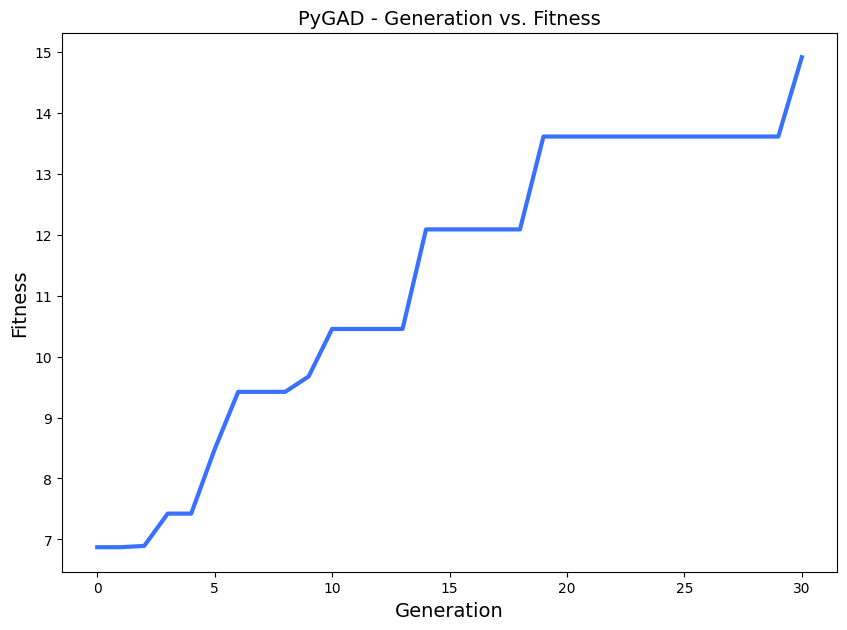



daily_change:  0           NaN
1      0.016818
2     -0.073951
3     -0.037284
4      0.000143
         ...   
256   -0.004791
257   -0.021299
258    0.019982
259   -0.000439
260    0.162206
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01            76   5.000000           NaN
1   2022-04-04            76   5.085531      0.016818
2   2022-04-05            76   4.735347     -0.073951
3   2022-04-06            76   4.565139     -0.037284
4   2022-04-07            76   4.565791      0.000143
..         ...           ...        ...           ...
256 2023-04-11            76   5.357470     -0.004791
257 2023-04-12            76   5.245742     -0.021299
258 2023-04-13            76   5.352700      0.019982
259 2023-04-14            76   5.350353     -0.000439
260 2023-04-17            94   6.386242      0.162206

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.019942
2     -0.076629
3     -0.04

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou

KeyError: -1

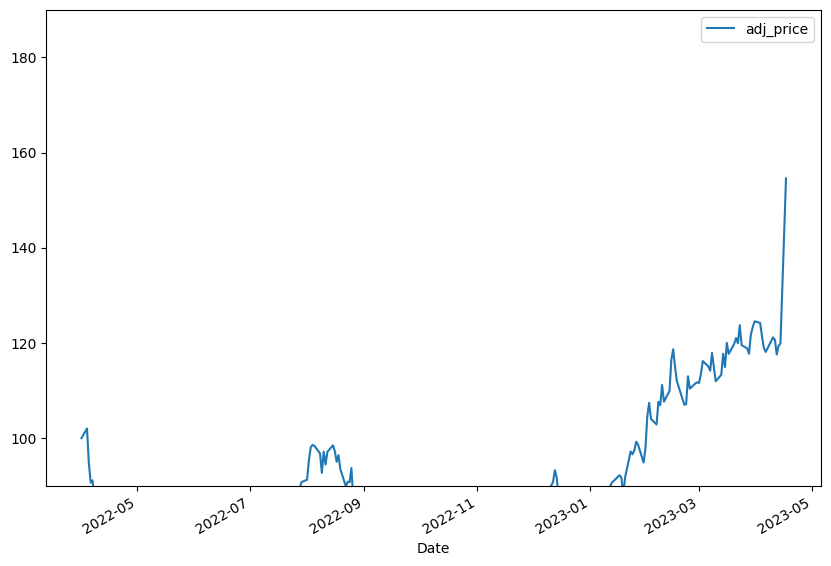

In [149]:
## Plot training, best resuls

ga_instance.plot_fitness(save_dir=None)
[solution, _, __] = ga_instance.best_solution()
visualize(df, solution)



daily_change:  0           NaN
1      0.009899
2     -0.061686
3     -0.026840
4      0.005942
         ...   
256   -0.005983
257   -0.017336
258    0.015535
259   -0.001236
260    0.093514
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           104   9.000000           NaN
1   2022-04-04           104   9.089980      0.009899
2   2022-04-05           104   8.561834     -0.061686
3   2022-04-06           104   8.338043     -0.026840
4   2022-04-07           104   8.387887      0.005942
..         ...           ...        ...           ...
256 2023-04-11           104  10.363094     -0.005983
257 2023-04-12           104  10.186500     -0.017336
258 2023-04-13           104  10.347243      0.015535
259 2023-04-14           104  10.334466     -0.001236
260 2023-04-17           122  11.400584      0.093514

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.009899
2     -0.061686
3     -0.02

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\3347007805.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\3347007805.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()


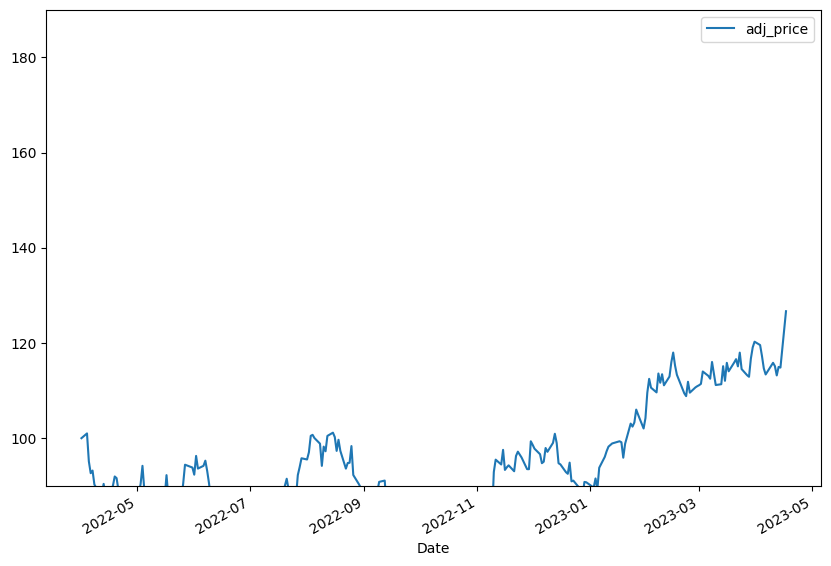

In [ ]:
## Top 10 performers benchmark

firsts = df.groupby("ticker_index", as_index=False).first()
firsts = firsts.rename({"adj_price": "first_price"}, axis=1)[["ticker_index", "first_price"]]
lasts = df.groupby("ticker_index", as_index=False).last()
lasts = lasts.rename({"adj_price": "last_price"}, axis=1)[["ticker_index", "last_price"]]

df_ = firsts.merge(lasts, on="ticker_index", how="left")
df_["return"] = df_["last_price"] / df_["first_price"]
df_ = df_.sort_values("return", ascending=False)
best_return = df_.head(10)["ticker_index"].unique()

visualize(df, best_return)

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\3347007805.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\3347007805.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()




daily_change:  0           NaN
1      0.014645
2     -0.053233
3     -0.022367
4      0.002564
         ...   
256   -0.004392
257   -0.018855
258    0.011346
259   -0.001557
260    0.043070
Name: daily_change, Length: 261, dtype: float64
portfolio:           Date  ticker_index  adj_price  daily_change
0   2022-04-01           258  23.000000           NaN
1   2022-04-04           258  23.341838      0.014645
2   2022-04-05           258  22.162089     -0.053233
3   2022-04-06           258  21.677235     -0.022367
4   2022-04-07           258  21.732952      0.002564
..         ...           ...        ...           ...
256 2023-04-11           258  22.138242     -0.004392
257 2023-04-12           258  21.728548     -0.018855
258 2023-04-13           258  21.977902      0.011346
259 2023-04-14           258  21.943726     -0.001557
260 2023-04-17           276  22.931378      0.043070

[261 rows x 4 columns]


daily_change:  0           NaN
1      0.014645
2     -0.053233
3     -0.02

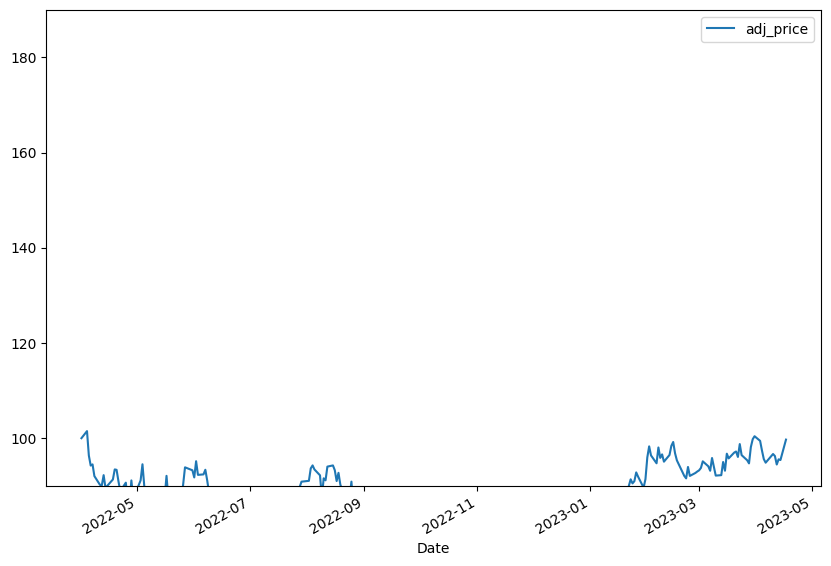

In [ ]:
## S&P 500 benchmark

visualize(df, df["ticker_index"].unique())